# Udacity Self Driving Car Nanodegree
## Vehicle Detection Project
### Brian Fischer

## Table of Contents
[Introduction](#introduction)

1. [Data Exploration](#data)
2. [Feature Extraction](#features)
3. [Train a Classifier](#train)
4. [Sliding Window Algorithm](#sliding_window)
5. [Video Pipeline](#pipeline)
6. [Heat Map Algorithm](#heat_map)
7. [Bounding Box Algorithm](#calculations)
8. [Run Pipeline on Project Video](#project_video)

## Introduction <a name="introduction"></a>

The goals / steps of this project are the following:

1. **Data Exploration**<br>
Review the available data set contents and quality<br>
<br>
1. **Feature Extraction**<br>
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images<br>
<br>
2. **Train a Classifier**<br>
From SVM, use the Linear Support Vector Classification (SVC)<br>
<br>
3. **Sliding Window Algorithm**<br>
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.<br>
<br>
4. **Test Sliding Window Algorithm**<br>
Test on static images and tweak the algorithm parameters
<br>
<br>
5. **Implement a Video Pipeline**<br>
Allow the algorithm to run frame by frame
<br>
<br>
6. **Heat Map Algorithm**<br>
Create a heat map of recurring detections in the pipeline, reject outliers and follow detected vehicles.
Threshold and label the heatmap.
<br>
<br>
7. **Bounding Box Algorithm**<br>
Estimate a bounding box for vehicles detected.  Needs to account for overlap and multiple vehicles
<br>
<br>
8. **Run Pipeline on Project Video**<br>
Run your pipeline on the project videos and 
Optional: Output a visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position!

## Imports <a name="imports"></a>
All of the required project imports are listed at the top of this notebook

In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from scipy.ndimage.measurements import label

%matplotlib inline

## Training Data

In [2]:
vehicles     = glob.glob('data/vehicles/**/*.png', recursive=True)
non_vehicles = glob.glob('data/non-vehicles/**/*.png', recursive=True)
print("Vehicle Images:\t\t", len(vehicles))
print('Non-vehicle Images:\t', len(non_vehicles))

Vehicle Images:		 8792
Non-vehicle Images:	 8968


## 1. Data Exploration <a name="data"></a>

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

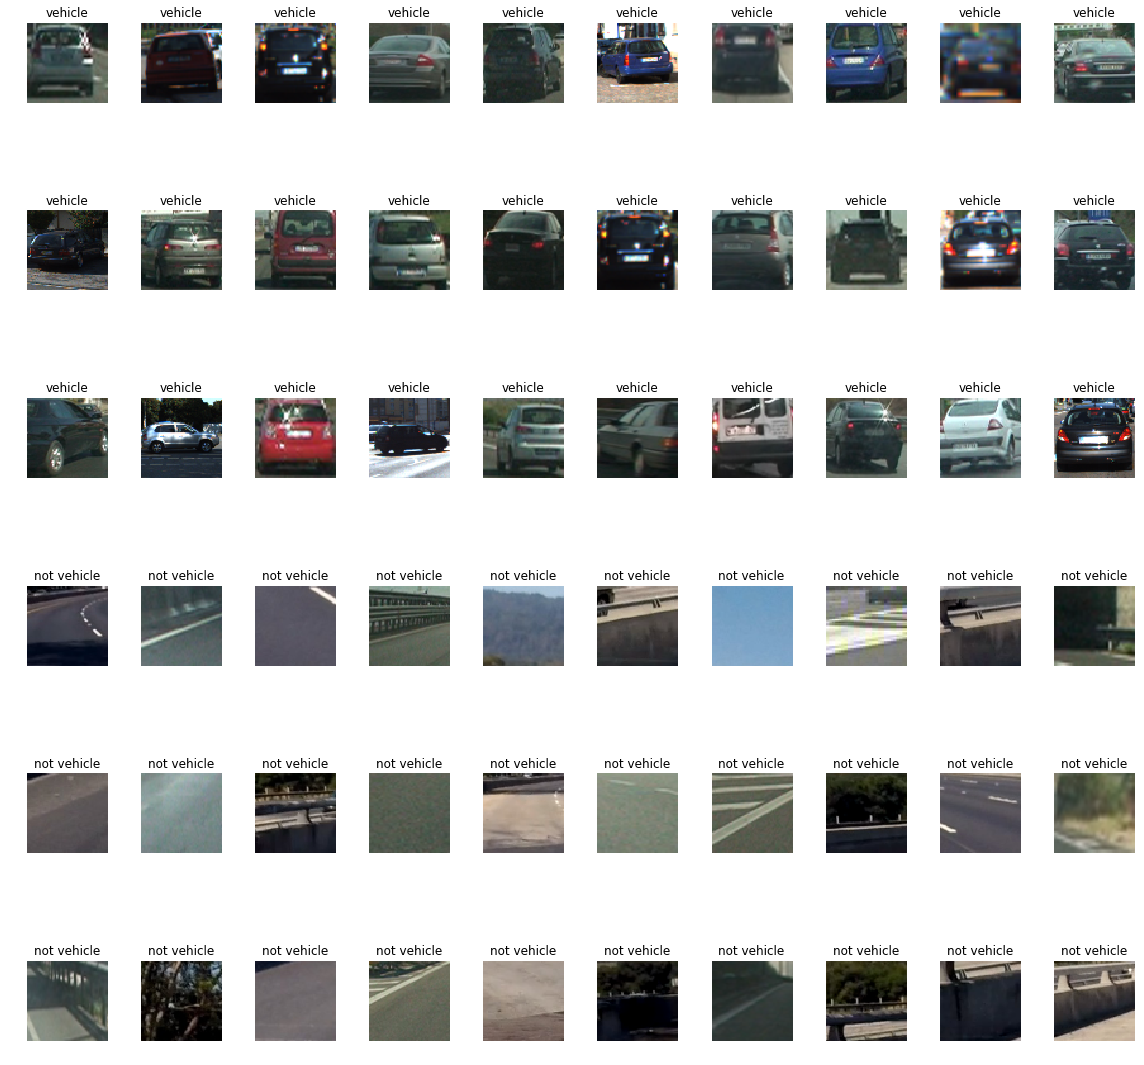

In [3]:
fig, axs = plt.subplots(6, 10, figsize=(16, 16))
axs = axs.ravel()


for i in range(30):
    img = cv2.imread(vehicles[np.random.randint(0,len(vehicles))])
    axs[i].axis('off')
    axs[i].set_title('vehicle')
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for i in range(30,60):
    img = cv2.imread(non_vehicles[np.random.randint(0,len(non_vehicles))])
    axs[i].axis('off')
    axs[i].set_title('not vehicle')
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig.tight_layout()

## 2. Feature Extraction
The following features are extracted from the labeled training set images:
* Perform spatial binning (binned color)
* Perform color histograms
* Perform a Histogram of Oriented Gradients (HOG)

In [4]:
# From Udacity 17.20 get_hog.py
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

Visualize the HOG feature extraction on a random image

(64, 64, 3)


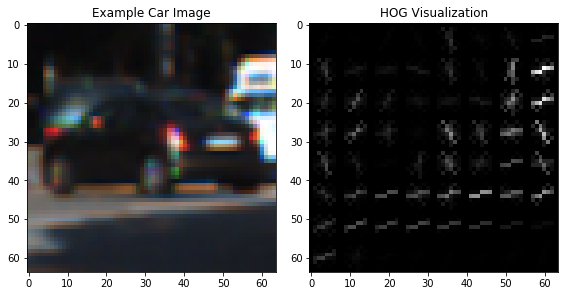

In [8]:
# From Udacity 17.20 get_hog.py
# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicles))
# Read in the image
image = mpimg.imread(vehicles[ind])
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.tight_layout()

ToDo: What about the block_norm="L2-Hys" from the previous Udacity exercise?  Should this be used?

Define functions for spatial binned color, color histograms, and HOG features

Modify the extract_features function provided by Udacity (from lesson 17.22 norm_shuffle.py) to accommodate hog feature extraction

In [41]:
# From Udacity 17.22 norm_shuffle.py

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB',
                         orient=9, pix_per_cell=8, cell_per_block=2, 
                         spatial_size=(32, 32),
                         hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)

        
        # Get HOG features (can only do one color channel at a time)
        hog_features = []
        color_channels = feature_image.shape[2]
        for channel in range(color_channels):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                    pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        # Flatten all channels into a single array
        hog_features = np.ravel(hog_features)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
    
    # Return list of feature vectors
    return features

The code below extracts features and normalizes the data

In [42]:
cspace = 'YUV' # Options are RGB, HSV, LUV, HLS, YUV
orient = 10
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 64
hist_range = (0, 256)

print('cspace\torient\tpix_per_cell\tcell_per_block\tspatial_size\thist_bins\thist_range')
print(cspace, '\t', orient, '\t', pix_per_cell, '\t\t', cell_per_block, '\t\t', spatial_size, '\t', hist_bins, '\t\t', hist_range)

cspace	orient	pix_per_cell	cell_per_block	spatial_size	hist_bins	hist_range
YUV 	 10 	 8 		 2 		 (32, 32) 	 64 		 (0, 256)


Elapsed: 375.5250201225281
Elapsed: 173.75650000572205
cspace orient pix_per_cell cell_per_block spatial_size hist_bins hist_range
YUV 9 8 2 (32, 32) 32 (0, 256)


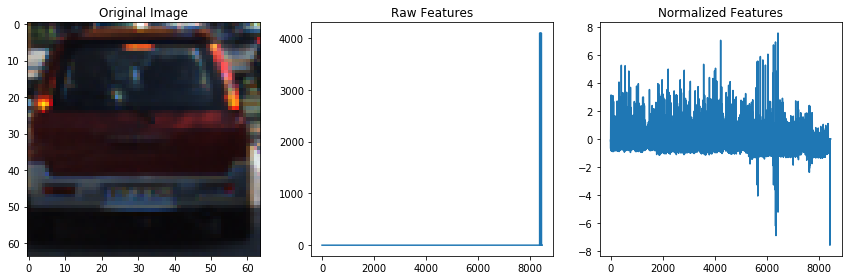

In [43]:
# From Udacity 17.22 norm_shuffle.py

# Define HOG parameters
cspace = 'YUV' # Options are RGB, HSV, LUV, HLS, YUV
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

t = time.time()
car_features = extract_features(vehicles, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range)

elapsed = time.time() - t
print('Elapsed: %s' % elapsed)
t = time.time()
notcar_features = extract_features(non_vehicles, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range)
elapsed = time.time() - t
print('Elapsed: %s' % elapsed)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    
    # Since we are combining different features (HOG, binned color, color histogram) we need to normalize
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Plot an example of raw and scaled features from a random image
    car_ind = np.random.randint(0, len(vehicles))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(vehicles[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

print('cspace', 'orient', 'pix_per_cell', 'cell_per_block', 'spatial_size', 'hist_bins', 'hist_range')
print(cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range)

We now create labels (INSERT WHAT TYPE OF CLASSIFICATION PROBLEM THIS IS) and the training test set

In [46]:
# From Udacity lesson 17.28

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## 3. Train a Classifier <a name="train"></a>
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.  The type of SVM classifier for this project will be a Linear Support Vector Classifier (SVC).

In [49]:
# From Udacity lesson 17.29
# Train a Liner SVC

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
22.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9854
My SVC predicts:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
0.03402 Seconds to predict 10 labels with SVC


## 4. Sliding Window Algorithm <a name="sliding_window"></a>
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.  The type of SVM classifier for this project will be a Linear Support Vector Classifier (SVC).

In [50]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
# From Udacity lesson 17.34

# Read in cars and notcars
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## 5. Video Pipeline
## 6. Heat Map Algorithm <a name="heat_map"></a>
## 7. Bounding Box Algorithm <a name="calculations"></a>
## 8. Run Pipeline on Project Video <a name="project_video"></a>